#### *PhotoDissociation Region Toolbox Notebooks*
-------------------------------------------------------------

# Example 3: Determining temperature and column density from $H_2$ rovibrational intensities


The intensity of an $H_2$ line is 
\begin{equation}
I = {A \Delta E~N_u \over 4\pi},~~~~~ (1)
\end{equation}
where $A$ is the Einstein A coefficient, $\Delta E$ is the energy difference associated with the transition, $N_u$ is the column density in the upper state.. Therefore, from a measured intensity $I$ one can calculate the column density 
\begin{equation}
N_u = 4\pi {I\over A\Delta E},~~~~~ (2)
\end{equation}
More typically one is interested in the normalized upper state column density $N_u/g_u$ for each transition (assuming LTE), where $g_u$ is the statistical weight. 

An excitation diagram plots the upper state energy of the transition $E_u/k$ on the x-axis versus $log(N_u/g_u)$ on the y-axis.   The statistical weight $g_u = (2I+1)\times(2J+1)$, where $I$ is
the total nuclear spin and $J$ is the rotational quantum number of the upper level.
Ortho hydrogen molecules have the spins of both the nuclei in the same direction $I=1$, and odd $J$; para molecules have nuclei that spin in opposite directions $I=0$, and even $J$. In LTE at temperatures $T\gtrsim 200$~K, the ortho-to-para ratio (OPR) of molecules is in the ratio  of 3 to 1.   In non-equilibrium environments,  OPR can be less than 3, and the actual $N_u/g_u$ will increase over its LTE value (see discussions in [Burton+ 1992](https://ui.adsabs.harvard.edu/abs/1992ApJ...399..563B) and [Sheffer+ 2011](https://ui.adsabs.harvard.edu/abs/2011ApJ...741...45S)). In such cases,  on a traditional plot that assumes OPR=3, $N_u$ for odd $J$ will be measured as too low.  This creates the so-called "zig-zag" pattern in the excitation diagram (See e.g.,
[Neufeld+ 1998, ](https://ui.adsabs.harvard.edu/abs/1998astro.ph..8101N)
[Fuente+1999, ](https://ui.adsabs.harvard.edu/abs/1999ApJ...518L..45F)
[Sternberg & Neufeld 1999](https://ui.adsabs.harvard.edu/abs/1999ApJ...516..371S)
).

Often, excitation diagrams show evidence of both "hot" and "cold" gas components, where the cold gas dominates the intensity in the low $J$ transitions and the hot gas dominates in the high $J$ transitions.  Given data over several transitions, 
one can fit for $T_{cold}, T_{hot}$, $N_{total} = N_{cold}+ N_{hot}$, and optionally OPR.  One needs at least 5 points to fit the temperatures and column densities (slope and intercept $\times 2$), though one could compute (not fit) them with only 4 points. To additionally fit OPR, one should have 6 points (5 degrees of freedom). 



## Using the PDR Toolbox to fit excitation diagrams. 
This example will go through the steps of computing the physical quantities of interest using $H_2$ line intensities plotted in an excitation diagram.  The first part use an the excitation diagram comprised of single pixel `Measurements`, both with fixed OPR and allowing it to vary, and the second part will show how fit the average quantities over spatial areas on intensity maps. A future `pdrtpy` release will allow fitting at every pixel.  

The first step is to import the modules we will need.

In [1]:
from pdrtpy.measurement import Measurement
from pdrtpy.tool.h2excitation import H2ExcitationFit, FitMap
from pdrtpy.plot.excitationplot import ExcitationPlot
import pdrtpy.pdrutils as utils
from pdrtpy.modelset import ModelSet
from pdrtpy.plot.modelplot import ModelPlot
from astropy.nddata import StdDevUncertainty, CCDData, NDData,NDDataArray,NDDataBase
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from lmfit import Parameters, fit_report
from lmfit.model import Model, ModelResult

/home/mpound/anaconda3-2021.11/lib/python3.9/site-packages/astropy/table/column.py:1157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


In [2]:
#In order for the `explore()` method to work in a noteboook, you have to invoke this directive
#(mpl-interactions package required).
%matplotlib ipympl

--------------------------------------
## Part 1: Single pixel observations
--------------------------------------

### We start with some test data, which are intensities of several $H_2$ lines
These are used to create `Measurements` to pass along to the fitting tool. 

In [3]:
intensity = dict()
intensity['H200S0'] = 3.00e-05
intensity['H200S1'] = 5.16e-04
intensity['H200S2'] = 3.71e-04
intensity['H200S3'] = 1.76e-03
intensity['H200S4'] = 5.28e-04
intensity['H200S5'] = 9.73e-04

a = []
for i in intensity:
    # For this example, set a largish uncertainty on the intensity.
    m = Measurement(data=intensity[i],uncertainty=StdDevUncertainty(intensity[i]),
                    identifier=i,unit="erg cm-2 s-1 sr-1")
    print(m)
    a.append(m)

3e-05 +/- 3e-05 erg / (cm2 s sr)
0.000516 +/- 0.000516 erg / (cm2 s sr)
0.000371 +/- 0.000371 erg / (cm2 s sr)
0.00176 +/- 0.00176 erg / (cm2 s sr)
0.000528 +/- 0.000528 erg / (cm2 s sr)
0.000973 +/- 0.000973 erg / (cm2 s sr)


## Instantiate the excitation diagram fitting tool
**NOTE: The intensities are assumed to be extinction-corrected**.

In [4]:
h = H2ExcitationFit(a)

### Before you do the fit, you can examine some of the quantities from equations (1) and (2)
The energy levels for the input `Measurements` $E_u/k$ in units of K
can be returned as a dictionary with the line identifiers as the keys (line=True) or with the J levels as the keys (line=False).

Similarly, the upper state column densities dictionary, which can be normalized by LTE $g_u$ or not using the `norm` keyword.

In [5]:
h.column_densities(line=False, norm=False)

{2: 1.8197148523853142e+20 +/- 1.8197148523853142e+20 1 / cm2,
 3: 1.1679462521205142e+20 +/- 1.1679462521205142e+20 1 / cm2,
 4: 1.0460072959833856e+19 +/- 1.0460072959833854e+19 1 / cm2,
 5: 1.0940196810403731e+19 +/- 1.0940196810403731e+19 1 / cm2,
 6: 1.0141849298692268e+18 +/- 1.0141849298692266e+18 1 / cm2,
 7: 7.234185990371995e+17 +/- 7.234185990371995e+17 1 / cm2}

## Plot the data
Each tool in the PDR Toolbox has an associated plotter which is instantiated by passing it a reference to the tool.   The tool here is `ExcitationPlot`.  The arguments are a reference to the `H2ExcitationFit` tool and a label for the data (LaTeX okay here, \$ signs will be added).  The `plot_diagram()` method can show the data normalized or unnormalized and can show the results of the fit with `show_Fit=True`.  As with other PDRT plots, the axis limits are controlled with `xmin, xmax, ymin, ymax.`

#### Create a plotter and make a excitation diagram
The default is to normalize $N_u$.

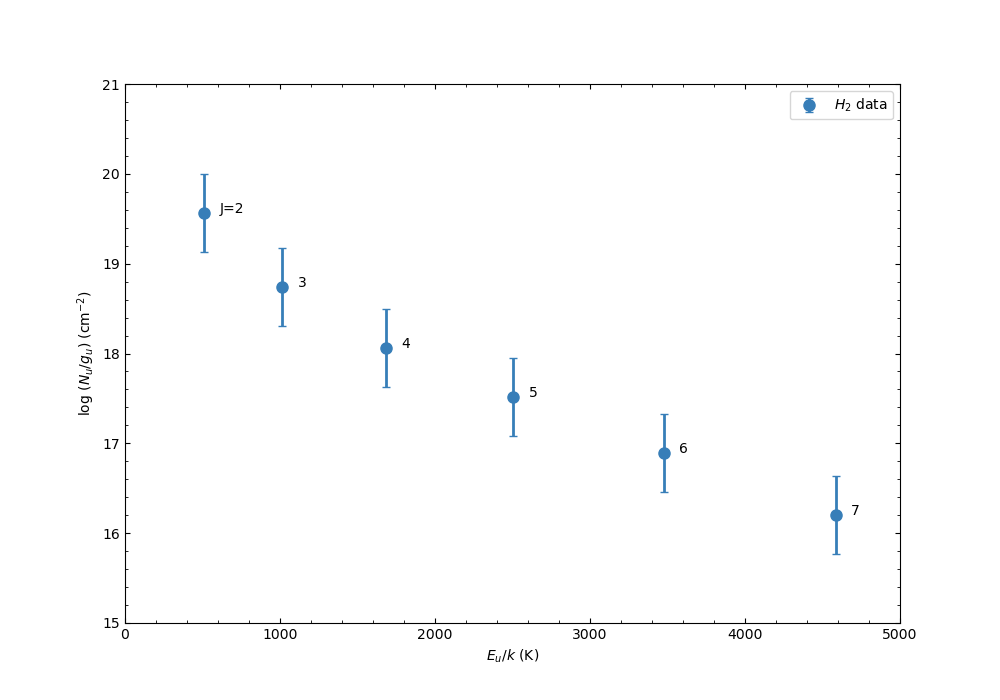

In [6]:
hplot = ExcitationPlot(h,"H_2")
hplot.ex_diagram(ymax=21)

## Fit a two-temperature model 
 The fit is done using the [lmfit package](https://github.com/lmfit/lmfit-py) and the fit result stored  the member variable `fit_result` is an [lmfit.model.ModelResult.](https://lmfit.github.io/lmfit-py/model.html#the-modelresult-class) ModelResult has methods by which you can [print the details of the fit](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult.fit_report) and [plot the data, residuals, and fit](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult.plot).  These are useful for a quick check of your results.   Fancier plotting with `ExcitationPlot` is described below. 
 
The cold, hot and total column densities, $N_{cold}, N_{hot}, N_{total}$, are computed using the $N_0$ determined from y-axis intercepts and the partition function $Z(T) = 0.0247~T ~ [1 - {\rm exp}( -6000/T)]^{-1}$ from [Herbst et al (1996)](http://articles.adsabs.harvard.edu/pdf/1996AJ....111.2403H).

In [7]:
h.run()

fitted 1 of 1 pixels
got 0 exceptions and 0 bad fits


## Plot the fit results
In the `ExcitationPlot` previously created, we can now plot the fitted parameters with the data, by setting `show_fit=True`.  The two component temperatures and total column density are displayed.   Leaving most options as defaults results in a pretty snazzy plot!

/home/mpound/anaconda3-2021.11/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


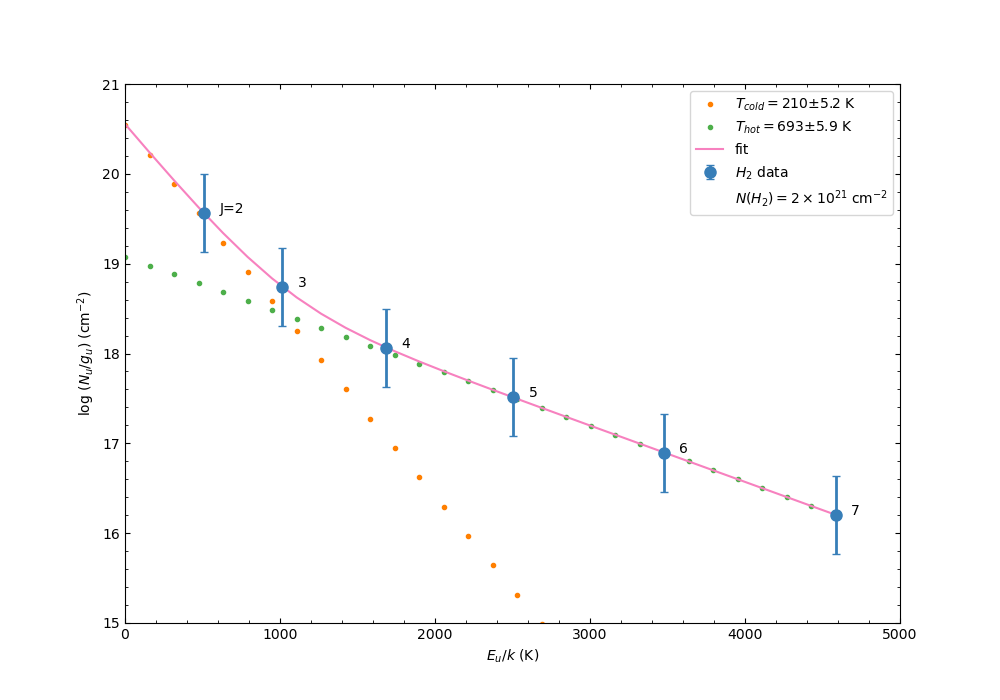

In [8]:
# make a plot showing the fit
hplot.ex_diagram(show_fit=True,ymax=21)

### The individual fitted parameters are accessible in the ExcitationFit
Most are returned as `Measurement` which can be used with Python f-strings. If OPR is fixed it will be returned as a float, if it was allowed to vary in the fit it will be a `Measurement`.  Here we also show a few examples of using [Python f-strings ](https://realpython.com/python-f-strings) for format Measurements.

In [9]:
print(f'T(cold) = {h.tcold}')
print("T(hot) = {:>8.3f}".format(h.thot))
print(f'N(cold) = {h.cold_colden:3.2E}')
print('N(hot) = ',h.hot_colden)
print(f'N(total) = {h.total_colden:+.1e}')
print(f"Ortho-to-para ratio (fixed) = {h.opr:.2f}")

T(cold) = 210.2342833828767 +/- 5.177215840246085 K
T(hot) =  692.821 +/-    5.877 K
N(cold) = 1.80E+21 +/- 1.27E+20 1 / cm2
N(hot) =  2.04927655031133e+20 +/- 8.783359590826143e+18 1 / cm2
N(total) = +2.0e+21 +/- +1.3e+20 1 / cm2
Ortho-to-para ratio (fixed) = 3.00 +/- 0.00 


## 2.  What if we want to fit the ortho-to-para ratio as well?
The previous example used the fixed LTE ortho-to-para ratios (and the example data were constructed that way).  But in real life, the OPR for the odd-J transitions can vary from it's LTE value of 3.
Let's start with some example data based on [Sheffer et al 2011](https://iopscience.iop.org/article/10.1088/0004-637X/741/1/45/pdf), Figure 9:

![Sheffer](ShefferEtAlFig9_sm.png)

They found $OPR = 1.88, T_{hot} = 685~{\rm K},  T_{cold}=206~{\rm K}$.   We'll create some example data by reading it off the above graph (tip o' the hat to [graphreader.com](http://graphreader.com))

In [10]:
intensity = dict()
intensity['H200S0'] = 3.003e-05
intensity['H200S1'] = 3.143e-04
intensity['H200S2'] = 3.706e-04
intensity['H200S3'] = 1.060e-03
# Add a point for J=6 so that the fit is not overconstrained.
intensity['H200S4'] = 5.282e-04
intensity['H200S5'] = 5.795e-04
a = []
for i in intensity:
    m = Measurement(data=intensity[i],uncertainty=StdDevUncertainty(0.75*intensity[i]),
                    identifier=i,unit="erg cm-2 s-1 sr-1")
    a.append(m)

Now set `fit_opr=True` in `run()`.   

In [11]:
hopr = H2ExcitationFit(a)
hopr.run(fit_opr=True)

fitted 1 of 1 pixels
got 0 exceptions and 0 bad fits


#### Examine the `ModelFit` nicely formatted for a notebook. 
This is an alternative to printing `fit_report()`.  The variables $m1, m2, n1, n2$ are the slopes and intercepts for the two temperature component linear fits.

In [12]:
hopr.fit_result.data[0]

## Plot the fit results
The LTE and fitted-OPR column densities will both be displayed on the plot showing the fit. The blue circles are the original column densities with LTE $g_u$, while the black triangles represent the column densities calculated using the fitted OPR. The fitted OPR successfully "de-zigzags" the data, making a smooth fit.  

/home/mpound/anaconda3-2021.11/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


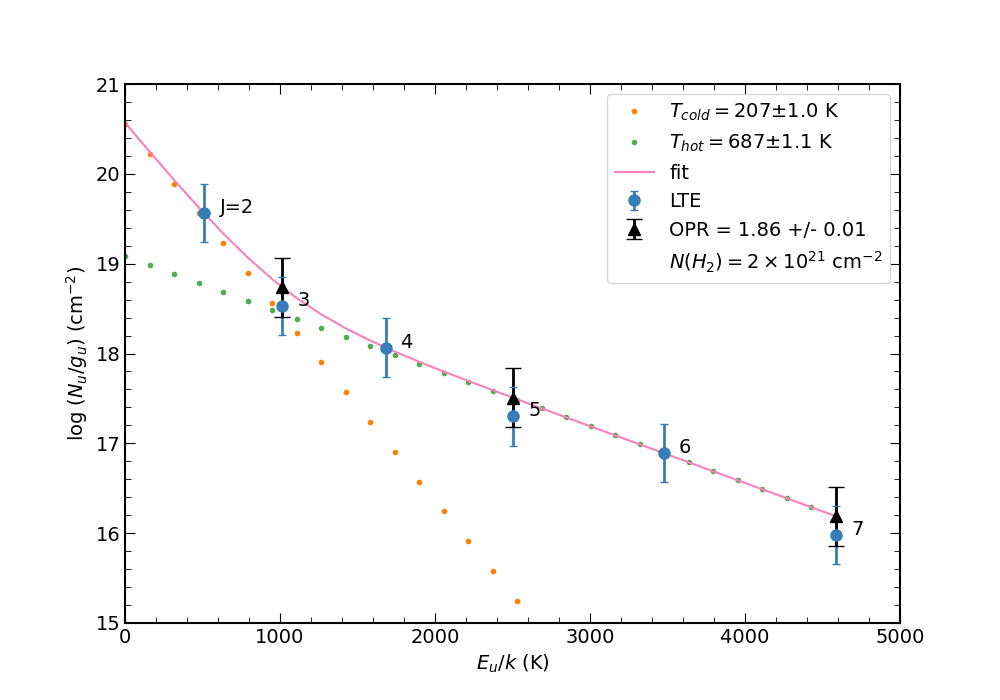

In [13]:
hploto = ExcitationPlot(hopr,"H_2")
# Set some rcParams to make a publication quality image
hploto._plt.rcParams["xtick.major.size"] = 7
hploto._plt.rcParams["xtick.minor.size"] = 4
hploto._plt.rcParams["ytick.major.size"] = 7
hploto._plt.rcParams["ytick.minor.size"] = 4
hploto._plt.rcParams['font.size'] = 14
hploto._plt.rcParams['axes.linewidth'] =1.5
hploto.ex_diagram(show_fit=True,ymax=21)
hploto.savefig('fitopr.png',dpi=300)

### Again, the individual fitted parameters are accessible in the ExcitationFit
Note that OPR is now returned as a `Measurement`.

In [14]:
print(f'T(cold) = {hopr.tcold}')
print("T(hot) = {:>8.3f}".format(hopr.thot))
print(f'N(cold) = {hopr.cold_colden:3.2E}')
print('N(hot) = ',hopr.hot_colden)
print(f'N(total) = {hopr.total_colden:+.1e}')
print(f"Ortho-to-para ratio = {hopr.opr:.2f}")

T(cold) = 207.03298983410892 +/- 1.012859843855601 K
T(hot) =  687.467 +/-    1.065 K
N(cold) = 1.84E+21 +/- 2.47E+19 1 / cm2
N(hot) =  2.0712280675081916e+20 +/- 1.4928308458932641e+18 1 / cm2
N(total) = +2.0e+21 +/- +2.5e+19 1 / cm2
Ortho-to-para ratio = 1.86 +/- 0.01 


--------------------------------------
## Part 2: Map (image) observations
--------------------------------------

### Read in some test $H_2$ intensity images from FITS files.  
The test maps are 2D Gaussian blobs with peak intensities as in the OPR-fitting example above, and with added Gaussian noise of 25% of the peak value.  The individual maps are read in and plotted here.

/home/mpound/anaconda3-2021.11/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


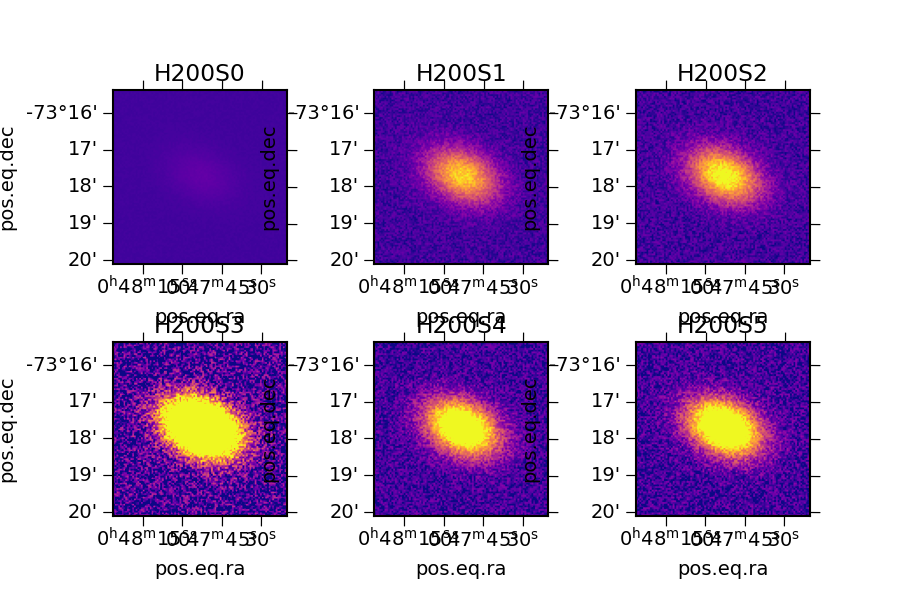

In [15]:
q = []
nu = []
for j in intensity:
    infile=f"../data/{j:s}_test_data.fits"
    m = Measurement.read(infile,identifier=j)
    q.append(m)
    nu.append(h.upper_colden(m,'cm-2'))
# pick a single scale for all the plots
vmin=q[1].data.min()
vmax=q[1].data.max()
    
fig,ax = plt.subplots(2,3,subplot_kw={'projection':q[0].wcs},figsize=(9,6))
i = 0
for a in ax:
    for b in a:
        b.imshow(q[i],origin="lower",vmin=vmin,vmax=vmax,cmap='plasma')
        b.set_title(q[i].id)
        i = i+1
plt.rcParams['font.size'] = 10
plt.subplots_adjust(wspace=0.5)

/home/mpound/anaconda3-2021.11/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


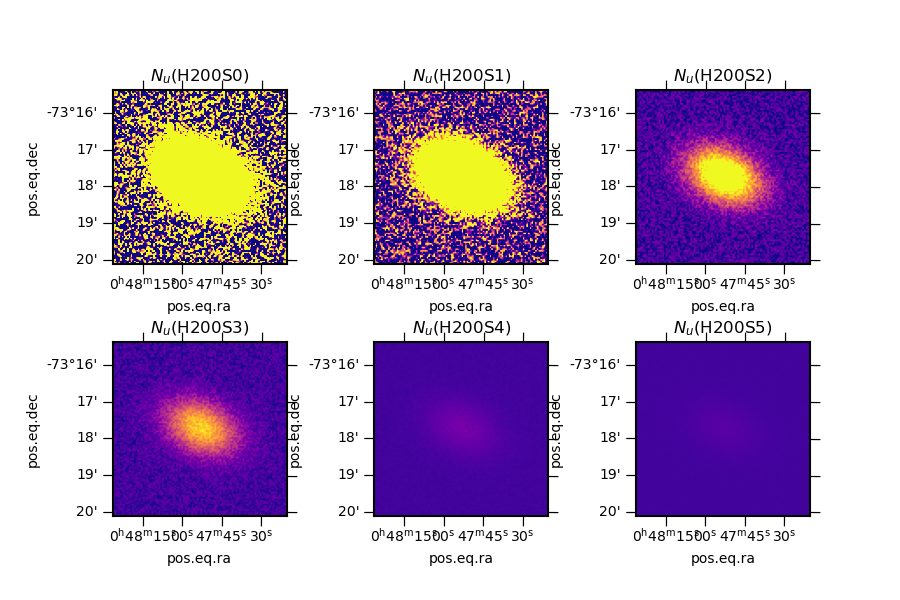

In [16]:
fig,ax = plt.subplots(2,3,subplot_kw={'projection':q[0].wcs},figsize=(9,6))
i = 0
vmin = nu[3].data.min()
vmax = nu[3].data.max()
for a in ax:
    for b in a:
        b.imshow(nu[i],origin="lower",vmin=vmin,vmax=vmax,cmap='plasma')
        b.set_title(rf"$N_u$({q[i].id:s})")
        i = i+1
plt.subplots_adjust(wspace=0.5)

### 2a) Fit to a rectangular spatial area in the image data over which the column densities are averaged

#### Here we select a rectangle centered on the blob, compute the average column densities,and plot the rectangle on the H200S1 map.
The area center `position` and `size` are in pixels. [`Astropy's Cutout2D`](https://docs.astropy.org/en/stable/api/astropy.nddata.utils.Cutout2D.html#astropy.nddata.utils.Cutout2D) is used underneath the hood. The statistical errors in the column densities are computed from the rms noise of the map which was specified in the FITS file. In this example, the subsequent error bars are smaller than the plot symbols.

N_u(H200S0)/g_u = 3.15e+19 +/- 9.11e+16 1 / cm2
N_u(H200S1)/g_u = 2.93e+18 +/- 8.47e+15 1 / cm2
N_u(H200S2)/g_u = 1.00e+18 +/- 2.90e+15 1 / cm2
N_u(H200S3)/g_u = 1.72e+17 +/- 4.99e+14 1 / cm2
N_u(H200S4)/g_u = 6.65e+16 +/- 1.95e+14 1 / cm2
N_u(H200S5)/g_u = 8.20e+15 +/- 2.39e+13 1 / cm2


/home/mpound/anaconda3-2021.11/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


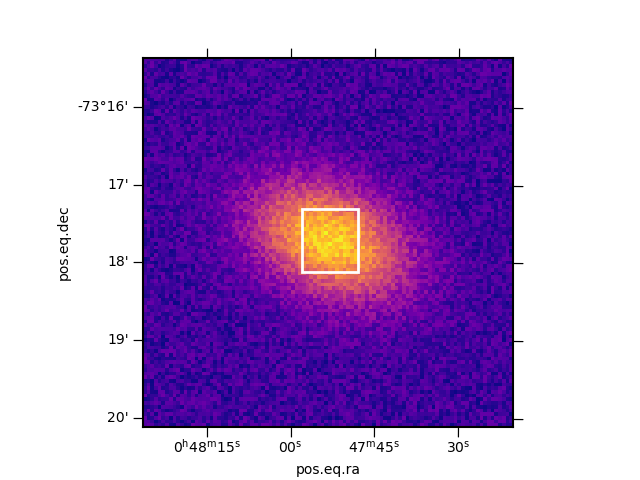

In [17]:
# Center of the box
x = 50
y = 50
# Size of the box
size=(15.0,17.0)
# instantiate the fitting tool with the Measurements.
hmap = H2ExcitationFit(q)
cd=hmap.average_column_density(norm=True,position=(x,y),size=size,line=True)
for k in cd:
    print(r"N_u({:s})/g_u = {:5.2e}".format(k,cd[k]))
    
# Show the rectangle on one of the maps
x0 = x-size[0]/2
y0 = y-size[1]/2
fig = plt.figure()
ax = plt.subplot(111,projection=q[1].wcs)
ax.imshow(q[1],origin="lower",vmin=q[1].data.min(),vmax=q[1].data.max(),cmap='plasma')
ax.add_patch(Rectangle((x0,y0),size[0],size[1],facecolor='None',ec='white',lw=2))

### Once we are satisfied with the choice, we pass the same rectangle to `run()`.

fitted 1 of 1 pixels
got 0 exceptions and 0 bad fits
[[Model]]
    Model(_modelfunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 6
    # variables        = 5
    chi-square         = 42645.5915
    reduced chi-square = 42645.5915
    Akaike info crit   = 63.2135183
    Bayesian info crit = 62.1723156
[[Variables]]
    m1:  -0.00210064 +/- 2.1947e-06 (0.10%) (init = -0.002041456)
    n1:   20.4942472 +/- 0.00124367 (0.01%) (init = 20.53957)
    m2:  -6.3358e-04 +/- 2.1077e-07 (0.03%) (init = -0.0008181398)
    n2:   19.0245454 +/- 6.7134e-04 (0.00%) (init = 19.66568)
    opr:  1.86942343 +/- 0.00142384 (0.08%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, n1)  = -0.950
    C(m2, n2)  = -0.937
    C(m1, m2)  = 0.681
    C(m1, n2)  = -0.651
    C(n1, m2)  = -0.549
    C(m1, opr) = -0.540
    C(n1, n2)  = 0.523
    C(n1, opr) = 0.456
    C(m2, opr) = -0.451
    C(n2, opr) = 0.226


/home/mpound/anaconda3-2021.11/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


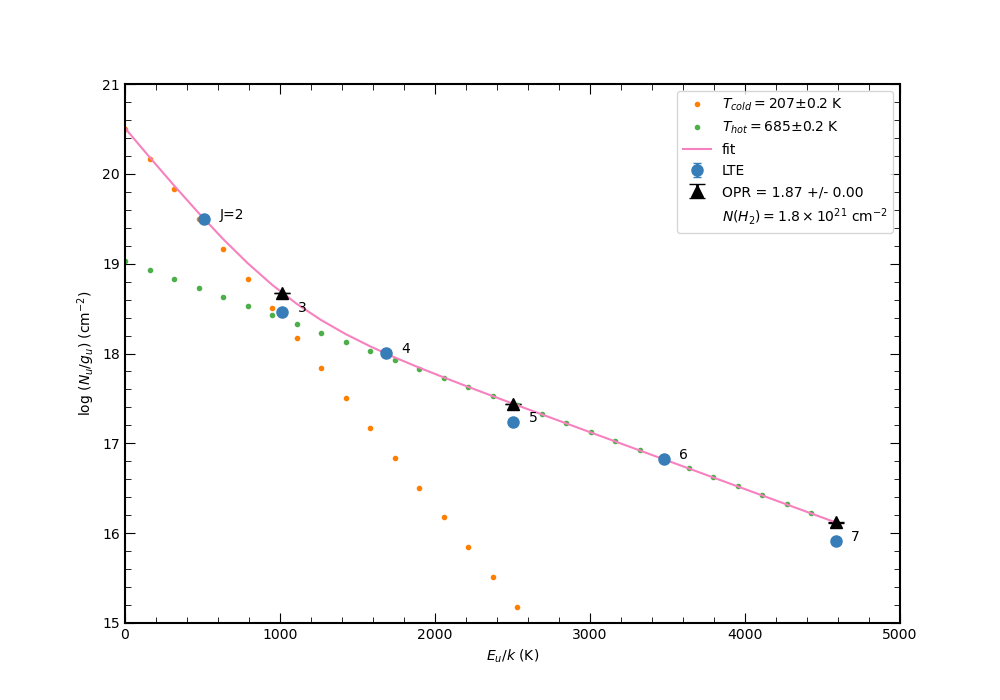

In [18]:
hmap.run(position=(x,y),size=size,fit_opr=True)
print(hmap.fit_result[0].fit_report())
hplot = ExcitationPlot(hmap,"H_2")
hplot.ex_diagram(position=(x,y),size=size,norm=True,show_fit=True,ymax=21)

### The individual fitted parameters from the ExcitationFit

In [19]:
print(f'T(cold) = {hopr.tcold}')
print("T(hot) = {:>8.3f}".format(hopr.thot))
print(f'N(cold) = {hopr.cold_colden:3.2E}')
print('N(hot) = ',hopr.hot_colden)
print(f'N(total) = {hopr.total_colden:+.1e}')
print(f"Ortho-to-para ratio = {hopr.opr:.2f}")

T(cold) = 207.03298983410892 +/- 1.012859843855601 K
T(hot) =  687.467 +/-    1.065 K
N(cold) = 1.84E+21 +/- 2.47E+19 1 / cm2
N(hot) =  2.0712280675081916e+20 +/- 1.4928308458932641e+18 1 / cm2
N(total) = +2.0e+21 +/- +2.5e+19 1 / cm2
Ortho-to-para ratio = 1.86 +/- 0.01 


## 2b) Run the fit on every pixel in the map
This is done by  setting `position` and `size` to None (which is the default). This will take a few minutes.


In [20]:
hmap.run(position=None,size=None,fit_opr=True)

/home/mpound/src/pdrtpy/pdrtpy/tool/h2excitation.py:745: RuntimeWarning: invalid value encountered in log10
  y = np.log10(_colden.data)
100%|████████████████████████████████████████████| 10000/10000 [01:08<00:00, 146.66it/s]


fitted 2084 of 10000 pixels
got 25 exceptions and 321 bad fits


### You can examine the results with the `explore` method
explore() plots data on the left panel and the fit at the selected pixel on the right panel.  Click on anywhere in the left panel to see the fit for that pixel.   This example uses the total column density for the left panel.

/home/mpound/anaconda3-2021.11/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Explore using position:  (50, 50)  size=1


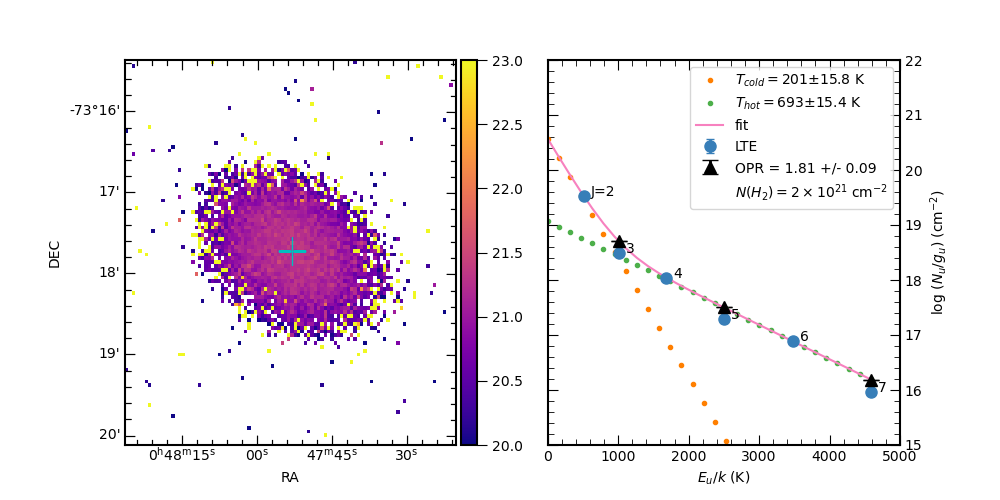

In [21]:
hplot.explore(data=hmap.colden("total"),vmin=20,vmax=23,figsize=(10,5),log=True,contours=False,fmt='c+')

### And here is `explore` with $T_{hot}$

Explore using position:  (50, 50)  size=1


/home/mpound/anaconda3-2021.11/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


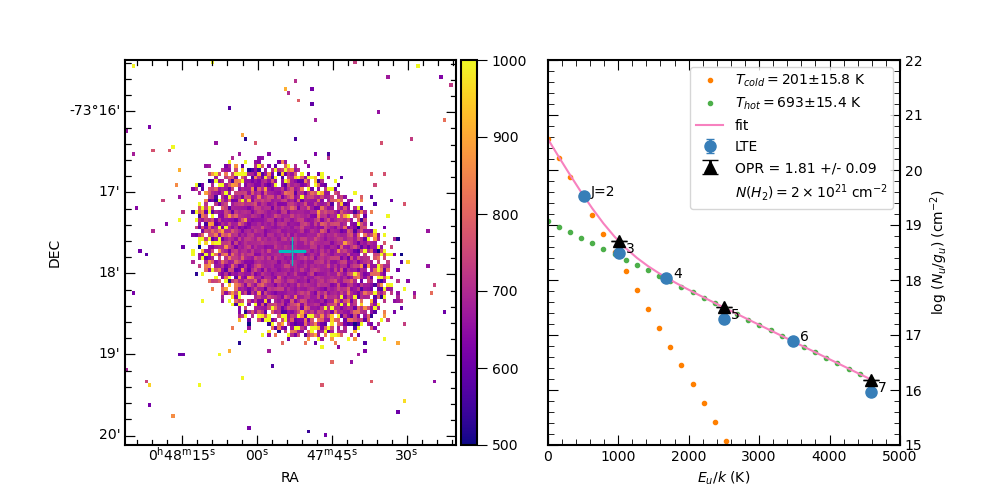

In [22]:
hplot.explore(data=hmap.thot,vmin=500,vmax=1000,figsize=(10,5),log=False,contours=False,fmt='c+')

### Finally, here are some plots of total column density and ortho-to-para ratio
`component` can be 'total', 'hot', or 'cold'

/home/mpound/anaconda3-2021.11/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/mpound/anaconda3-2021.11/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


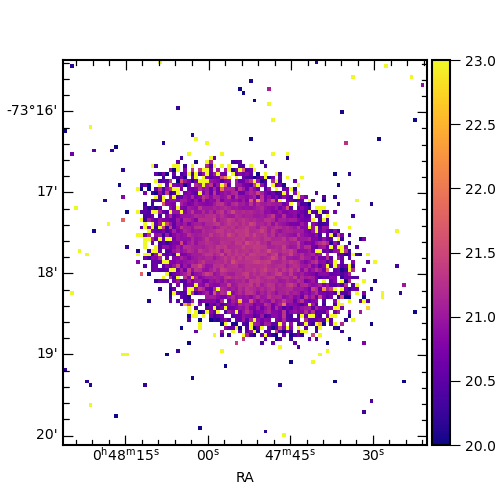

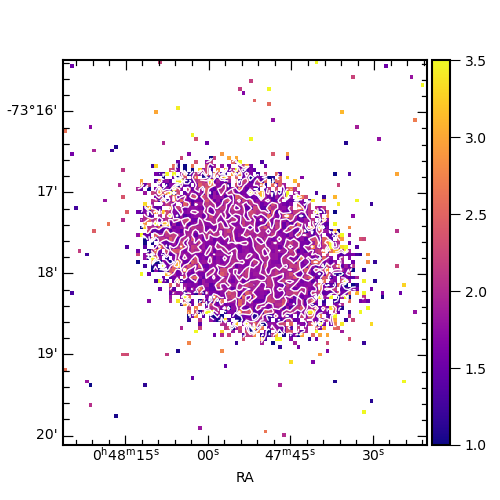

In [23]:
hplot.column_density(component='total',log=True,norm='simple',contours=False,vmin=20,vmax=23)
hplot.opr()

### Look at some aggregate values

In [24]:
# N(J=0) Hot column density = intercept on y axis of T_hot
c0 = hmap._j0_colden['hot']
# N(J=0) Cold  column density = intercept on y axis T_cold
c1 = hmap._j0_colden['cold']
# Total cold column density
c2 = hmap.colden('cold')
# Total hot column density
c3 = hmap.colden('total')
print(f'Mean values: {np.nanmean(c0):.2e}, {np.nanmean(c1):.2e}, {np.nanmean(c2):.2e}, {np.nanmean(c3):.2e}')
print(f' Max values: {np.nanmax(c0):.2e}, {np.nanmax(c1):.2e}, {np.nanmax(c2):.2e}, {np.nanmax(c3):.2e}')

Mean values: 4.81e+18, 1.02e+27, 5.01e+26, 1.31e+35
 Max values: 1.55e+19, 1.00e+30, 4.92e+29, 1.07e+38
